In [3]:
from sentinelhub import SHConfig

config = SHConfig()

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

/home/sc.uni-leipzig.de/jn906hluu/.conda/envs/s2_image/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12","CLM"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12,
                sample.CLM];
    }
"""

evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["CLM"],
    output: { bands: 1 }
  }
}

function evaluatePixel(sample) {
  return [sample.CLM];
}
"""

evalscript_clm = """
//VERSION=3
function setup() {
  return {
    input: ["CLM"],
    output: { bands: 1 }
  }
}

function evaluatePixel(sample) {
  return [sample.CLM];
}
"""


In [38]:
path = '/work/users/jn906hluu/S2_Frankenwald_quartal/'
list_dir = os.listdir(path)
shape_file_path = '/work/users/jn906hluu/RSP/ForestCoverPatternStudy/Layers/D48/D48.shp'

quicklook_dir = '/work/users/jn906hluu/to_gif_quartal/'

folder = list_dir[22]
    
image_path = path + folder + '/response.tiff'

In [41]:
import json

geojson = shapefile.to_json()

# print the output
print(json.dumps(json.loads(geojson), indent=1))

{
 "type": "FeatureCollection",
 "features": [
  {
   "id": "0",
   "type": "Feature",
   "properties": {
    "wg_bu": 53.0,
    "bez_bu_wg": "Th\u00fcringer Gebirge"
   },
   "geometry": {
    "type": "Polygon",
    "coordinates": [
     [
      [
       10.243953471741227,
       50.993936604905144
      ],
      [
       10.246337641971268,
       50.99190646349918
      ],
      [
       10.248147047697232,
       50.99088370132129
      ],
      [
       10.251054329759377,
       50.98948704170076
      ],
      [
       10.254576105691559,
       50.9877802915184
      ],
      [
       10.256584361397351,
       50.98697443378261
      ],
      [
       10.261439216348519,
       50.985026066032745
      ],
      [
       10.261699448626098,
       50.98494490323705
      ],
      [
       10.262124961051208,
       50.984767968519535
      ],
      [
       10.26227729554486,
       50.98470462701633
      ],
      [
       10.26265978975527,
       50.984495703145605
      ],

In [32]:
for i, j in zip(list(shapefile['geometry'][0]), list(shapefile['geometry'][1])):
    print(i,j)

TypeError: 'Polygon' object is not iterable

In [40]:
shape_file_path = '/work/users/jn906hluu/RSP/ForestCoverPatternStudy/Layers/D48/D48.shp'

import rasterio
import geopandas as gpd
from rasterio.features import geometry_mask

shapefile = gpd.read_file(shape_file_path)

# Open the raster file
with rasterio.open(image_path) as src:
    # Get the CRS of the raster file
    raster_crs = src.crs
    # Get the shape of the raster file
    raster_shape = src.shape

    shapefile = shapefile.to_crs(src.crs)
    # Get the transform of the raster file
    raster_transform = src.transform
    geometry = shapefile.geometry
    # Create a mask from the geometry
    mask_tw = geometry_mask([geometry[0]], raster_shape, raster_transform, invert=True)
    mask_fw = geometry_mask([geometry[1]], raster_shape, raster_transform, invert=True)
    mask_all = ~mask_fw & ~mask_tw

In [4]:
bbox = [10.294189,50.307024,11.961365,50.972242]
resolution = 50

frankenwald_bbox = BBox(bbox=bbox, crs=CRS.WGS84)
frankenwald_size = bbox_to_dimensions(frankenwald_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {frankenwald_size} pixels")

Image shape at 50 m resolution: (2315, 1547) pixels


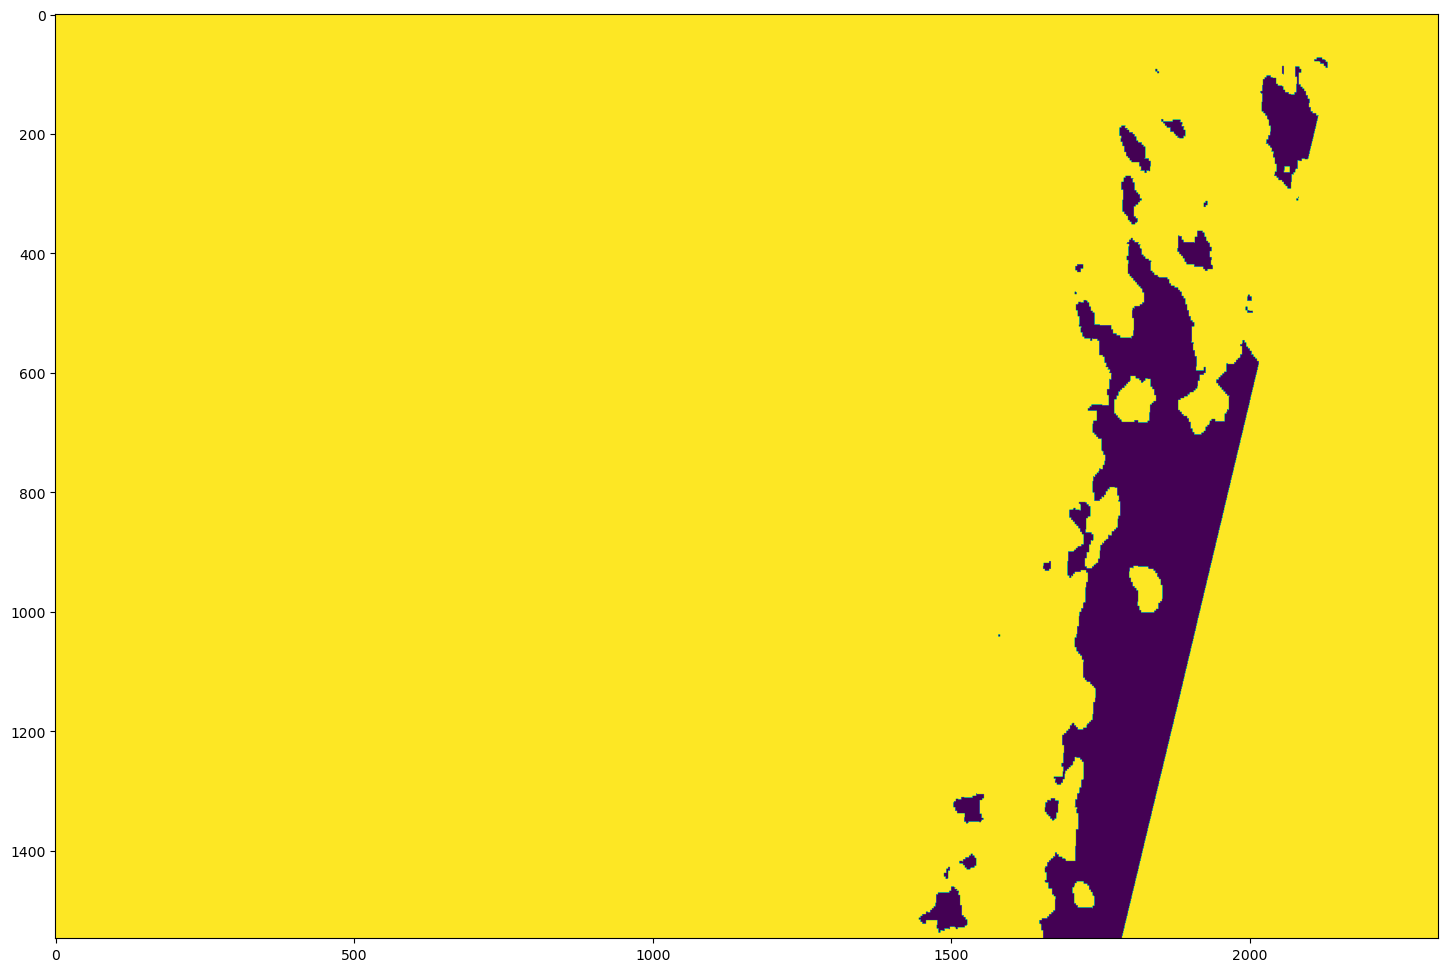

In [8]:
request_true_color = SentinelHubRequest(
    data_folder="/home/josh/Desktop/S2_Frankenwald/",
    evalscript=evalscript_clm,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            #mosaicking_order=MosaickingOrder.LEAST_CC,
            time_interval=("2022-08-01", "2022-08-31"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=frankenwald_bbox,
    size=frankenwald_size,
    config=config,
)



true_color_imgs = request_true_color.get_data(save_data=False)
plt.figure(figsize=(20, 12))
plt.imshow(true_color_imgs[0])

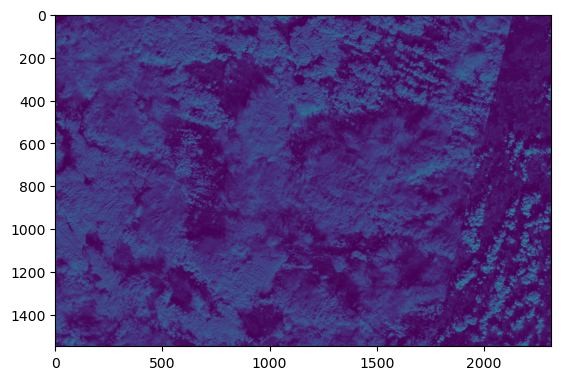

In [22]:
plt.imshow(true_color_imgs[0][:,:,-1])